# attempting nri

In [44]:
import configparser
import json
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA

import utils

config = configparser.ConfigParser()
config.read('../config.ini')
g = config['general']

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
start_year = 2007
end_year = 2010
years = [yr for yr in range(start_year, end_year + 1)]
months = [f'{mo:02}' for mo in range(1,13)]

In [9]:
users = pd.read_csv(
    os.path.join(g['save_path'], f'science/users/user_label_counts_all.csv'),
)
users.head()

,author,year,month,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,---sniff---,2009,3,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0
1,---sniff---,2009,7,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,---sniff---,2009,8,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1
3,---sniff---,2010,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,---sniff---,2010,2,0,4,0,0,3,0,0,0,0,0,0,0,1,0,0


In [10]:
users['sum'] = users.drop(['author', 'year', 'month'], axis=1).sum(axis=1)
users.head()

,author,year,month,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,sum
0,---sniff---,2009,3,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,3
1,---sniff---,2009,7,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2
2,---sniff---,2009,8,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,3
3,---sniff---,2010,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,2
4,---sniff---,2010,2,0,4,0,0,3,0,0,0,0,0,0,0,1,0,0,8


In [13]:
# find authors with 'sum' > K for at least M months
K = 3
M = 24

authors_with_high_sum = (
    users.loc[users['sum'] > K, 'author']
    .value_counts()
    .loc[lambda x: x >= M]
    .index.tolist()
)

print(f"Number of authors with at least {M} entries with 'sum' > {K}: {len(authors_with_high_sum)}")
authors_with_high_sum[:10]  # Display the first 10 authors

Number of authors with at least 24 entries with 'sum' > 3: 288


['artman',
 'mutatron',
 'Mr_Smartypants',
 'NoMoreNicksLeft',
 'anonymous-coward',
 'Shaper_pmp',
 'BraveSirRobin',
 'Whisper',
 'M0b1u5',
 'otakucode']

In [68]:
# Filter the DataFrame for authors in authors_with_high_sum
df = users[users['author'].isin(authors_with_high_sum)]

# if an author is missing a particular time period (month or year), 
# impute the value using the previous period

df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Set MultiIndex (author and date)
df = df.set_index(['author', 'date'])

# Drop author, year, and month columns
df = df.drop(['year', 'month'], axis=1)

# Build full index: every author for each month from 2007-01 to 2010-12
authors = df.index.get_level_values('author').unique()
all_dates = pd.date_range('2007-01-01', '2010-12-01', freq='MS')
full_index = pd.MultiIndex.from_product([authors, all_dates], names=['author', 'date'])

# Reindex the DataFrame to include missing months
df = df.reindex(full_index).copy()

# Impute missing values in columns 0–14 using forward fill per author
num_cols = [str(i) for i in range(15)]
df.loc[:, num_cols] = df.groupby(level='author')[num_cols].ffill().bfill()

# Optionally, recalc 'sum' (if you want it to match the imputed values)
df['sum'] = df[num_cols].sum(axis=1)

# Reset index if desired
df = df.reset_index()

# Sort by author, year, and month
df = df.sort_values(by=['author', 'date'])

# Create a dictionary assigning authors to an author_label (int)
author_labels_dict = {author: idx for idx, author in enumerate(df['author'].unique())}
author_labels_reverse_dict = {idx: author for author, idx in author_labels_dict.items()}

# Create an array with the author label for each row in df
author_labels = df['author'].map(author_labels_dict).values

# drop author and date
df = df.drop(columns=['author', 'date'])

# Divide all columns by the value in the 'sum' column
df = df.div(df['sum'], axis=0)

# Drop the 'sum' column
df = df.drop(columns=['sum'])

# Convert the remaining DataFrame to a NumPy ndarray
X = df.values

X[:5,:]

/local/scr/stmorse/TMPDIR/ipykernel_334039/2390361892.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))


array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [69]:
X[10,:]

array([0.66666667, 0.        , 0.        , 0.        , 0.        ,
       0.33333333, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [70]:
author_labels[10], author_labels_reverse_dict[author_labels[10]]

(np.int64(0), 'AMerrickanGirl')

In [71]:
X.shape

(13824, 15)

In [72]:
zt = TSNE(n_components=2).fit_transform(X)

In [73]:
zk = KernelPCA(n_components=2, kernel='rbf').fit_transform(X)

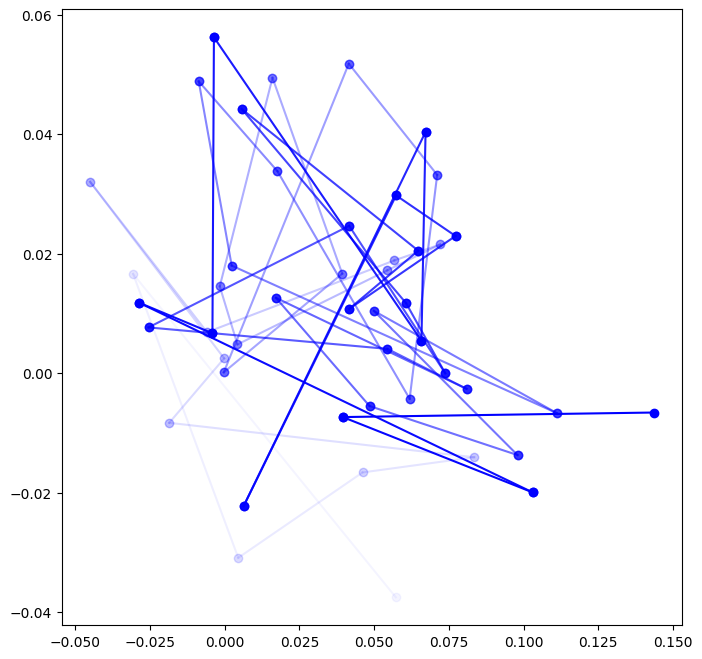

In [75]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

z = zk

idx = np.where(author_labels == 91)[0]
for i in range(len(idx) - 1):
    x1, y1 = z[idx[i]]
    x2, y2 = z[idx[i + 1]]
    ax.plot([x1, x2], [y1, y2], 'bo-', alpha=1 - i / len(idx))

plt.show()

In [77]:
n_samples = 20000
n_users = 5
max_t = 12*4

data = np.zeros((n_samples, max_t, 15, n_users))

total_n_users = len(author_labels_dict.keys())
print(f'Total users: {total_n_users}')

for s in range(n_samples):
    sampled_users = np.random.choice(range(total_n_users), size=n_users, replace=False)

    for i, u in enumerate(sampled_users):
        idx = np.where(author_labels == u)[0]
        data[s, :, :, i] = X[idx, :]

Total users: 288


In [80]:
np.save('../nri/data/science/loc_train_rc.npy', data[:10000])
np.save('../nri/data/science/loc_valid_rc.npy', data[10000:15000])
np.save('../nri/data/science/loc_test_rc.npy', data[15000:])

# checking on users 

In [1]:
import configparser
import json
import os
import pickle

import bz2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.cluster
import sklearn.manifold
import scipy.special

import utils

In [2]:
%load_ext autoreload
%autoreload 2

In [46]:
config = configparser.ConfigParser()
config.read('../config.ini')
g = config['general']

In [5]:
start_year = 2007
end_year = 2010
years = [yr for yr in range(start_year, end_year + 1)]
months = [f'{mo:02}' for mo in range(1,13)]

In [9]:
# check how many users
users = []
for year in years:
    for month in months:
        meta = pd.read_csv(
            os.path.join(g['meta_path'], f'metadata_{year}-{month}.csv'),
            compression='gzip'
        )
        
        # get unique users for this period
        unique_users = meta[meta['subreddit']=='science']['author'].unique()

        # append to `users`
        users = (
            pd.concat([pd.Series(users), pd.Series(unique_users)])
            .drop_duplicates()
            .tolist()
        )

        print(f'{year}-{month}: total {len(users)}')

2007-01: total 693
2007-02: total 1272
2007-03: total 1884
2007-04: total 2422
2007-05: total 3086
2007-06: total 3651
2007-07: total 4245
2007-08: total 5019
2007-09: total 5700
2007-10: total 6766
2007-11: total 7845
2007-12: total 9071
2008-01: total 10346
2008-02: total 11388
2008-03: total 12822
2008-04: total 14290
2008-05: total 15913
2008-06: total 17349
2008-07: total 18690
2008-08: total 19992
2008-09: total 21205
2008-10: total 22561
2008-11: total 23968
2008-12: total 25591
2009-01: total 27449
2009-02: total 29595
2009-03: total 31797
2009-04: total 33849
2009-05: total 36462
2009-06: total 38865
2009-07: total 41667
2009-08: total 44230
2009-09: total 47117
2009-10: total 50957
2009-11: total 54449
2009-12: total 58826
2010-01: total 63632
2010-02: total 68287
2010-03: total 73013
2010-04: total 76834
2010-05: total 81188
2010-06: total 85480
2010-07: total 89213
2010-08: total 93057
2010-09: total 98460
2010-10: total 104316
2010-11: total 110283
2010-12: total 116709


In [47]:
with open(os.path.join(g['save_path'], 'science/tfidf/tfidf_2007-2010.pkl'), 'rb') as f:
    tfidf = pickle.load(f)

In [11]:
users = {}

for year in years:
    users[year] = pd.read_csv(
        os.path.join(g['save_path'], f'science/users/user_label_counts_{year}.csv'),
    )
    users[year]['year'] = year

In [12]:
for year in years:
    print(len(users[year]))

1080
2634
5782
10475


In [13]:
# Find authors present in all dataframes
common_authors = set(users[years[0]]['author'])
for year in years[1:]:
    common_authors = common_authors.intersection(users[year]['author'])

# Filter the dataframes for those authors and concatenate them
filtered_users = []
for year in years:
    filtered_users.append(users[year][users[year]['author'].isin(common_authors)])

# Vertically concatenate the filtered dataframes
c_users = pd.concat(filtered_users, axis=0)

# Reorder rows so author's entries appear together
c_users = c_users.sort_values(by=['author', 'year']).reset_index(drop=True)

c_users.head()

,author,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,year
0,AbouBenAdhem,2,0,0,8,4,2,1,5,2,4,0,1,0,1,5,2007
1,AbouBenAdhem,0,1,1,3,2,2,6,3,1,8,3,0,3,1,6,2008
2,AbouBenAdhem,1,0,1,8,2,2,6,15,2,3,2,0,0,3,12,2009
3,AbouBenAdhem,1,1,1,1,8,0,0,12,0,3,0,3,0,0,15,2010
4,Aerik,2,0,5,3,3,3,5,2,5,10,0,6,2,2,3,2007


In [14]:
c_users['author'].nunique()

213

In [15]:
X = c_users.drop(['author', 'year'], axis=1).values
X = X / X.sum(axis=1, keepdims=True)

Xt = sklearn.manifold.TSNE(n_components=2).fit_transform(X)

c_users['tx'] = Xt[:,0]
c_users['ty'] = Xt[:,1]

c_users.head()

,author,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,year,tx,ty
0,AbouBenAdhem,2,0,0,8,4,2,1,5,2,4,0,1,0,1,5,2007,8.583735,17.453100
1,AbouBenAdhem,0,1,1,3,2,2,6,3,1,8,3,0,3,1,6,2008,14.148195,12.319158
2,AbouBenAdhem,1,0,1,8,2,2,6,15,2,3,2,0,0,3,12,2009,-8.673806,21.469877
3,AbouBenAdhem,1,1,1,1,8,0,0,12,0,3,0,3,0,0,15,2010,-6.410945,23.018929
4,Aerik,2,0,5,3,3,3,5,2,5,10,0,6,2,2,3,2007,14.236448,3.982126


In [17]:
X[0,:]

array([0.05714286, 0.        , 0.        , 0.22857143, 0.11428571,
       0.05714286, 0.02857143, 0.14285714, 0.05714286, 0.11428571,
       0.        , 0.02857143, 0.        , 0.02857143, 0.14285714])

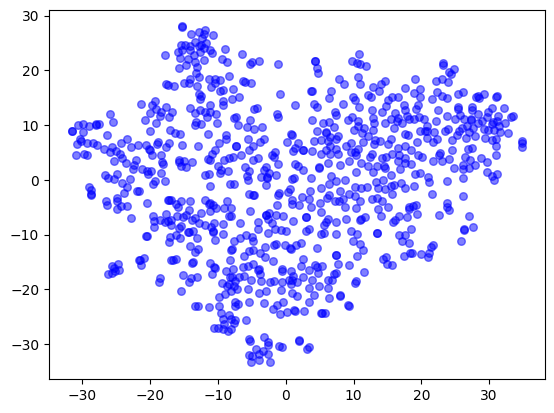

In [18]:
plt.scatter(c_users['tx'], c_users['ty'], s=30, c='b', alpha=0.5)

In [33]:
# cluster all users (ignore year)
# put label in column
# create a dataframe with the 4 labels
# cluster *that*

km = sklearn.cluster.KMeans(n_clusters=15).fit(X)
labels = km.predict(X)
c_users['label'] = labels

# Pivot the dataframe to have authors as rows and years as columns with labels as values
author_labels = (
    c_users.pivot(index='author', columns='year', values='label')
    .reset_index()
)

# Ensure year columns are in numeric order
author_labels = author_labels[sorted(author_labels.columns, key=lambda x: (isinstance(x, int), x))]

# Convert to a numpy array
Y = author_labels.drop(['author'], axis=1).values

km2 = sklearn.cluster.KMeans(n_clusters=15).fit(Y)
labels2 = km2.predict(Y)
author_labels['label'] = labels2

/local/scr/stmorse/TMPDIR/ipykernel_601564/4064626952.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(g['tx'], g['ty'], s=30, c=colors[c], alpha=0.5)


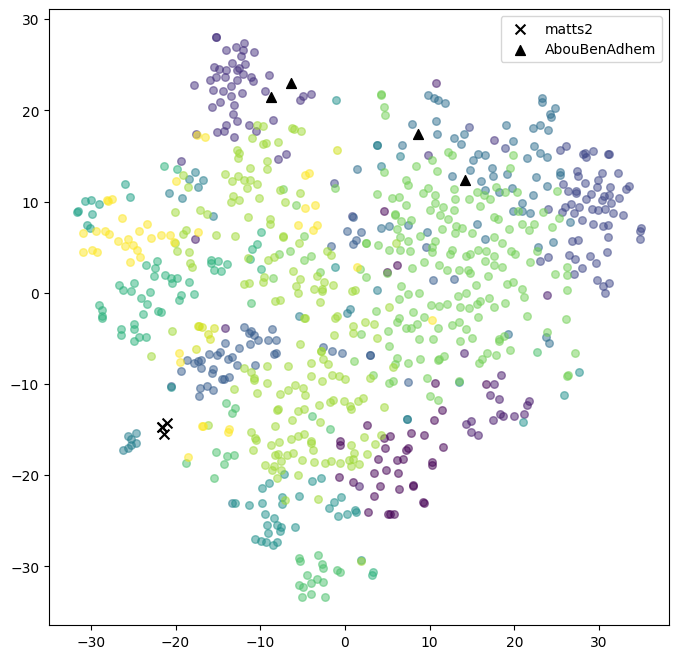

In [ ]:
n_clusters = km.n_clusters

fig, ax = plt.subplots(1,1, figsize=(8,8))
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))
for c in range(n_clusters):
    gr = c_users[(c_users['label'] == c) & (~c_users['author'].isin(['matts2', 'AbouBenAdhem']))]
    ax.scatter(gr['tx'], gr['ty'], s=30, c=colors[c], alpha=0.5)

gr2 = c_users[(c_users['author']=='matts2')]
ax.scatter(gr2['tx'], gr2['ty'], s=50, marker='x', c='k', label='matts2')

gr2 = c_users[(c_users['author']=='AbouBenAdhem')]
ax.scatter(gr2['tx'], gr2['ty'], s=50, marker='^', c='k', label='AbouBenAdhem')

# ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))
ax.legend()
plt.show()

In [52]:
c_users[c_users['author']=='AbouBenAdhem']

,author,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,year,tx,ty,label
0,AbouBenAdhem,2,0,0,8,4,2,1,5,2,4,0,1,0,1,5,2007,8.583735,17.453100,5
1,AbouBenAdhem,0,1,1,3,2,2,6,3,1,8,3,0,3,1,6,2008,14.148195,12.319158,11
2,AbouBenAdhem,1,0,1,8,2,2,6,15,2,3,2,0,0,3,12,2009,-8.673806,21.469877,2
3,AbouBenAdhem,1,1,1,1,8,0,0,12,0,3,0,3,0,0,15,2010,-6.410945,23.018929,2


In [55]:
tfidf['tfidf'][3]['keywords']

array(['snakes', 'zoo', 'critters', 'spiders', 'insects', 'skinner',
       'elephants', 'whales', 'shrimp', 'zoos', 'rodents', 'mammal',
       'lizards', 'nest', 'insect', 'frog', 'predator', 'apes', 'octopus',
       'lisa'], dtype=object)

In [67]:
from functools import partial
from scipy.spatial.distance import pdist, squareform

In [68]:
trajectories = []
labels = []

for name, group in c_users.groupby('author'):
    # Sort by step just to be safe
    group = group.sort_values(by='year')
    # Extract coordinate columns, flatten them
    coords = group.drop(['author', 'year', 'tx', 'ty', 'label'], axis=1).values.flatten()
    trajectories.append(coords)
    labels.append(name)

# Convert to NumPy array of shape (num_trajectories, T*D)
trajectories = np.array(trajectories)

def sum_of_l2_per_time(u, v, T, D):
    # Reshape from (T*D,) to (T, D)
    u_reshaped = u.reshape(T, D)
    v_reshaped = v.reshape(T, D)
    # Sum of Euclidian norms across time
    return np.sum(np.linalg.norm(u_reshaped - v_reshaped, axis=1))

custom_metric = partial(sum_of_l2_per_time, T=4, D=15)

dist_matrix = squareform(pdist(trajectories, metric=custom_metric))

clustering = sklearn.cluster.AgglomerativeClustering(
    n_clusters=10, 
    # affinity='precomputed', 
    metric='precomputed',
    linkage='average'
)
cluster_labels = clustering.fit_predict(dist_matrix)

results = pd.DataFrame({'name': labels, 'cluster': cluster_labels})


In [66]:
trajectories.shape

(213, 60)

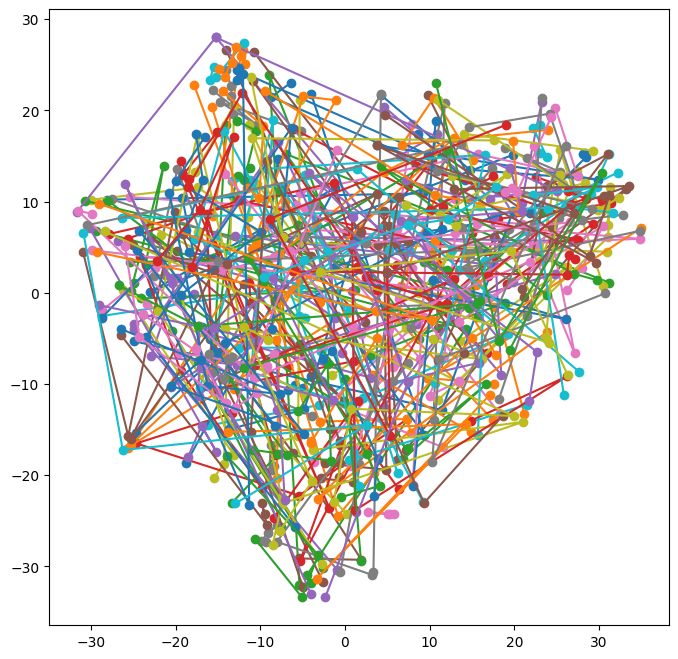

In [71]:
sample_authors = results[results['cluster']==0]['name']

fig, ax = plt.subplots(1,1, figsize=(8,8))
for author in sample_authors:
    data = c_users[c_users['author']==author].sort_values(by='year')
    ax.plot(data['tx'], data['ty'], marker='o', label=author)
    # for _, row in data.iterrows():
    #     plt.annotate(str(row['year']), (row['tx'], row['ty']), textcoords="offset points", xytext=(5,5))

# ax.legend()
plt.show()

In [40]:
author_labels[author_labels['label']==5]

year,author,2007,2008,2009,2010,label
0,AbouBenAdhem,5,11,2,2,5
7,Codebender,2,12,2,12,5
29,MyrddinE,4,11,5,2,5
36,OlympicPirate,1,12,6,6,5
46,RickyP,2,12,6,0,5
86,crwper,2,12,0,2,5
140,madmax_br5,1,11,7,3,5
145,matthank,3,11,5,3,5
153,monesy,6,12,2,6,5
204,wartexmaul,1,11,3,11,5


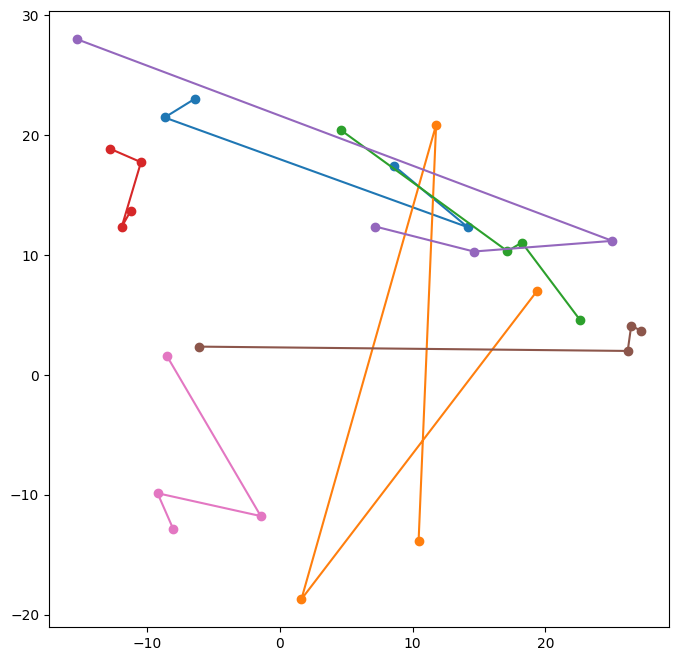

In [29]:
sample_authors = author_labels[author_labels['label']==3]['author']

fig, ax = plt.subplots(1,1, figsize=(8,8))
for author in sample_authors:
    data = c_users[c_users['author']==author].sort_values(by='year')
    ax.plot(data['tx'], data['ty'], marker='o', label=author)
    # for _, row in data.iterrows():
    #     plt.annotate(str(row['year']), (row['tx'], row['ty']), textcoords="offset points", xytext=(5,5))

# ax.legend()
plt.show()

In [20]:
Y[0,:]

array([2, 2, 5, 5], dtype=int32)

In [26]:
# Pivot the TSNE coordinates for tx and ty by author and year
tx = c_users.pivot(index='author', columns='year', values='tx')
ty = c_users.pivot(index='author', columns='year', values='ty')

# Compute differences only for those that contain both 2007 and 2008 data
d_users = pd.DataFrame({
    'author': tx.index,
    'dx': tx[2008] - tx[2007],
    'dy': ty[2008] - ty[2007]
})

d_users.reset_index(drop=True, inplace=True)

# d_users now contains columns: 'author', 'dx', 'dy'
d_users.head()

,author,dx,dy
0,711was_a_retail_job,-19.018187,2.167688
1,7oby,24.162418,17.229307
2,AaronRowe,-4.460289,-21.631430
3,AbouBenAdhem,14.719017,-13.848330
4,Adrewmc,-8.821045,-21.569397


In [30]:
km = sklearn.cluster.KMeans(n_clusters=20)
traj_X = d_users.drop(['author'], axis=1).values
km.fit(traj_X)
traj_labels = km.predict(traj_X)
d_users['cluster'] = traj_labels
print(np.unique(traj_labels, return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=int32), array([ 40,  19,  33,  27,  10,  11,  10, 109,  13,  25,  24,  14,  34,
        21,  20,  29,   6,   6,  36,  17]))


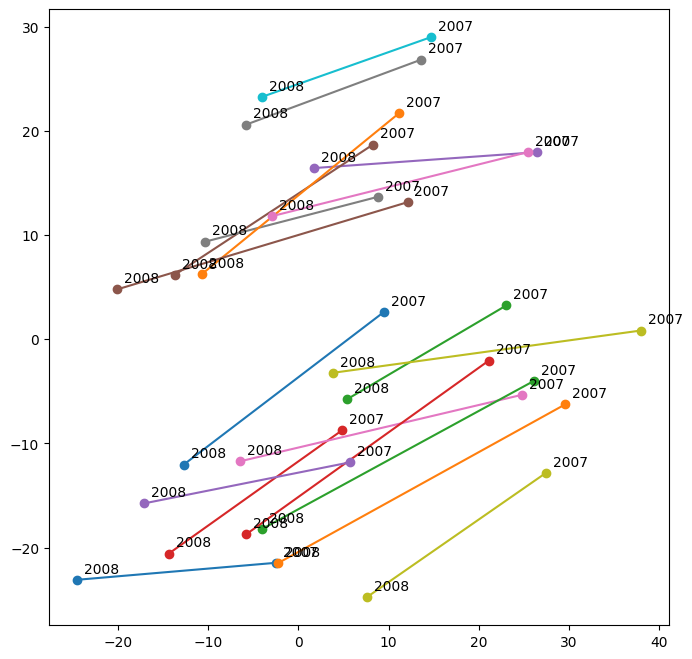

In [31]:
sample_authors = d_users[d_users['cluster']==1]['author']

fig, ax = plt.subplots(1,1, figsize=(8,8))
for author in sample_authors:
    data = c_users[c_users['author']==author].sort_values(by='year')
    ax.plot(data['tx'], data['ty'], marker='o', label=author)
    for _, row in data.iterrows():
        plt.annotate(str(row['year']), (row['tx'], row['ty']), textcoords="offset points", xytext=(5,5))

# ax.legend()
plt.show()

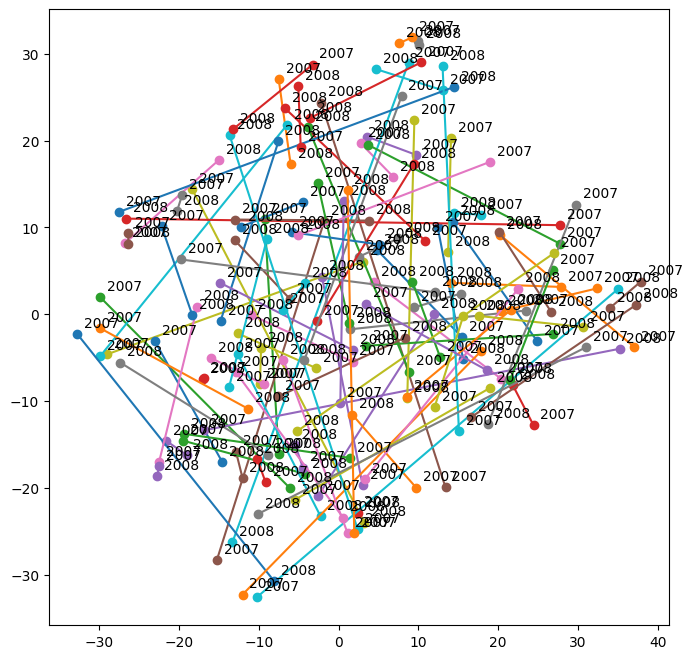

In [16]:
sample_authors = np.random.choice(c_users['author'].unique(), size=100, replace=False)

fig, ax = plt.subplots(1,1, figsize=(8,8))
for author in sample_authors:
    data = c_users[c_users['author']==author].sort_values(by='year')
    ax.plot(data['tx'], data['ty'], marker='o', label=author)
    for _, row in data.iterrows():
        plt.annotate(str(row['year']), (row['tx'], row['ty']), textcoords="offset points", xytext=(5,5))

# ax.legend()
plt.show()

# users -- full period

In [26]:
users = pd.read_csv(
    os.path.join(g['save_path'], 'science/users/user_label_counts_2007-2010.csv'),
    # compression='gzip'
)
users.head()

,author,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,---sniff---,0,4,0,0,3,0,0,0,0,0,0,0,1,0,0
1,-Borfo-,0,2,0,0,2,0,6,0,6,1,0,0,0,1,3
2,-GuybrushThreepwood-,0,3,0,0,0,2,2,1,0,0,0,0,1,0,0
3,-J-,0,0,1,0,1,1,4,0,0,5,2,2,1,0,0
4,-Mu-,1,0,0,0,4,0,0,1,0,5,1,4,9,0,0


In [27]:
users.shape

(15027, 16)

In [38]:
X = users.drop(['author'], axis=1).values
X = scipy.special.softmax(X, axis=1)

cm = sklearn.cluster.KMeans(
    n_clusters=40,
)
cm.fit(X)
np.unique(cm.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39], dtype=int32),
 array([1630,  426,  600,   52,  219,  261,  315,  213,  308,  235,  375,
         314,  210,  145,  232,  359,  379,  458,  270,  256,  340,  644,
         228,  375,  198,  234,  627,  326,  304,  983,  402,  241,  699,
         395,  320,  272,  592,  181,  304,  105]))

In [43]:
tsne = sklearn.manifold.TSNE(
    n_components=2,
    perplexity=35,
    random_state=314,
)
Xt = tsne.fit_transform(X)
Xt.shape

(15027, 2)

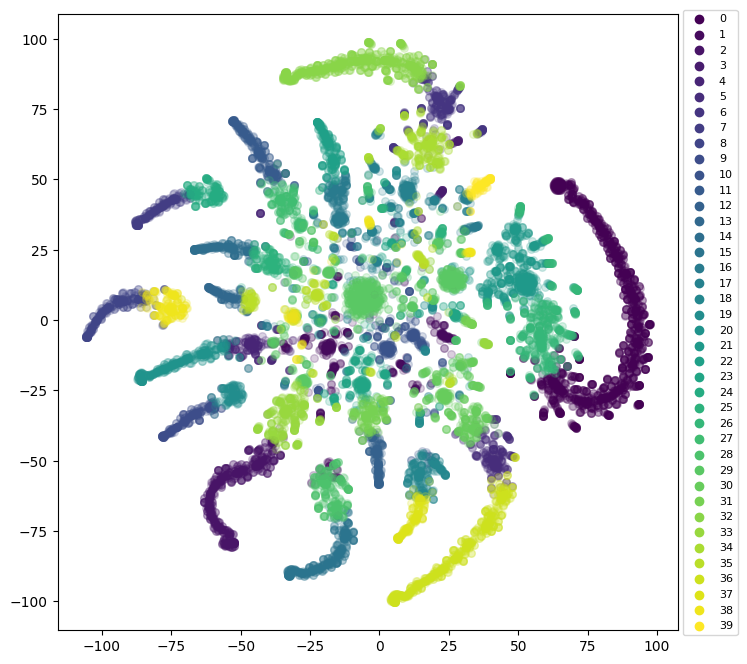

In [49]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

colors = plt.cm.viridis(np.linspace(0, 1, len(np.unique(cm.labels_))))
for cluster_label, color in zip(np.unique(cm.labels_), colors):
    if cluster_label == -1:
        continue
    cluster_points = Xt[cm.labels_ == cluster_label]
    ax.scatter(
        cluster_points[:, 0], cluster_points[:, 1], 
        s=30, color=color, alpha=0.2)
    ax.scatter([], [], color=color, label=f'{cluster_label}')

# gix = np.where(cm.labels_ == -1)[0]
# ax.scatter(Xt[gix,0], Xt[gix,1], s=30, color='k', alpha=0.05)
ax.legend(loc='center left', fontsize=8, bbox_to_anchor=(1, 0.5))
plt.show()

In [57]:
uix = np.where(cm.labels_==22)[0]
users.loc[uix[:5],:]

,author,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
4,-Mu-,1,0,0,0,4,0,0,1,0,5,1,4,9,0,0
106,7805,0,2,0,0,4,15,1,1,1,1,3,1,19,0,12
193,AggroBoy,0,0,0,0,0,2,2,0,0,0,0,0,4,0,0
231,Allakhellboy,1,0,0,1,0,1,2,0,0,1,1,0,4,0,0
379,AtomicAmish,1,4,0,0,0,2,3,0,0,2,3,2,6,1,0


In [51]:
with open(os.path.join(g['save_path'], 'science/tfidf/tfidf_2007-2010.pkl'), 'rb') as f:
    tfidf = pickle.load(f)

In [59]:
tfidf['tfidf'][12]['keywords']

array(['bradley', 'reuters', 'blogspam', 'submitter', 'ai2', 'newsweek',
       'climateaudit', 'fbi', 'truthers', 'poe', 'crock', 'oprr',
       'debunk', 'explosives', 'editors', 'siphon', 'ai1', 'wsj', 'nyt',
       'outlets'], dtype=object)

# older

In [21]:
with open(os.path.join(g['save_path'], 'sr/movies/tfidf/tfidf_2010-2.pkl'), 'rb') as f:
    tfidf = pickle.load(f)

In [22]:
tfidf['tfidf'][8]['keywords']

array(['loved', 'pacing', 'terrible', 'sort', 'cinema', 'scenes',
       'intense', 'superb', 'friends', 'needed', 'direction', 'myself',
       'power', 'done', 'found', 'disappointed', 'audience', 'theater',
       'terrifying', 'sat'], dtype=object)

In [23]:
metadata = pd.read_csv(
    os.path.join(g['meta_path'], f'metadata_2010-01.csv'),
    compression='gzip'
)
metadata.head()

,id,name,created_utc,parent_id,subreddit,subreddit_id,author,idx
0,c0i12v3,t1_c0i12v3,1262304000,t3_akcbt,politics,t5_2cneq,David_ungerer,0
1,c0i12v4,t1_c0i12v4,1262304001,t1_c0i12q0,offbeat,t5_2qh11,JayDurst,1
2,c0i12v5,t1_c0i12v5,1262304001,t3_akcaj,gaming,t5_2qh03,uninhibited,2
3,c0i12v7,t1_c0i12v7,1262304002,t3_akddz,gonewild,t5_2qq5c,parl,3
4,c0i12v8,t1_c0i12v8,1262304004,t1_c0i12gs,IAmA,t5_2qzb6,epsilondelta,4


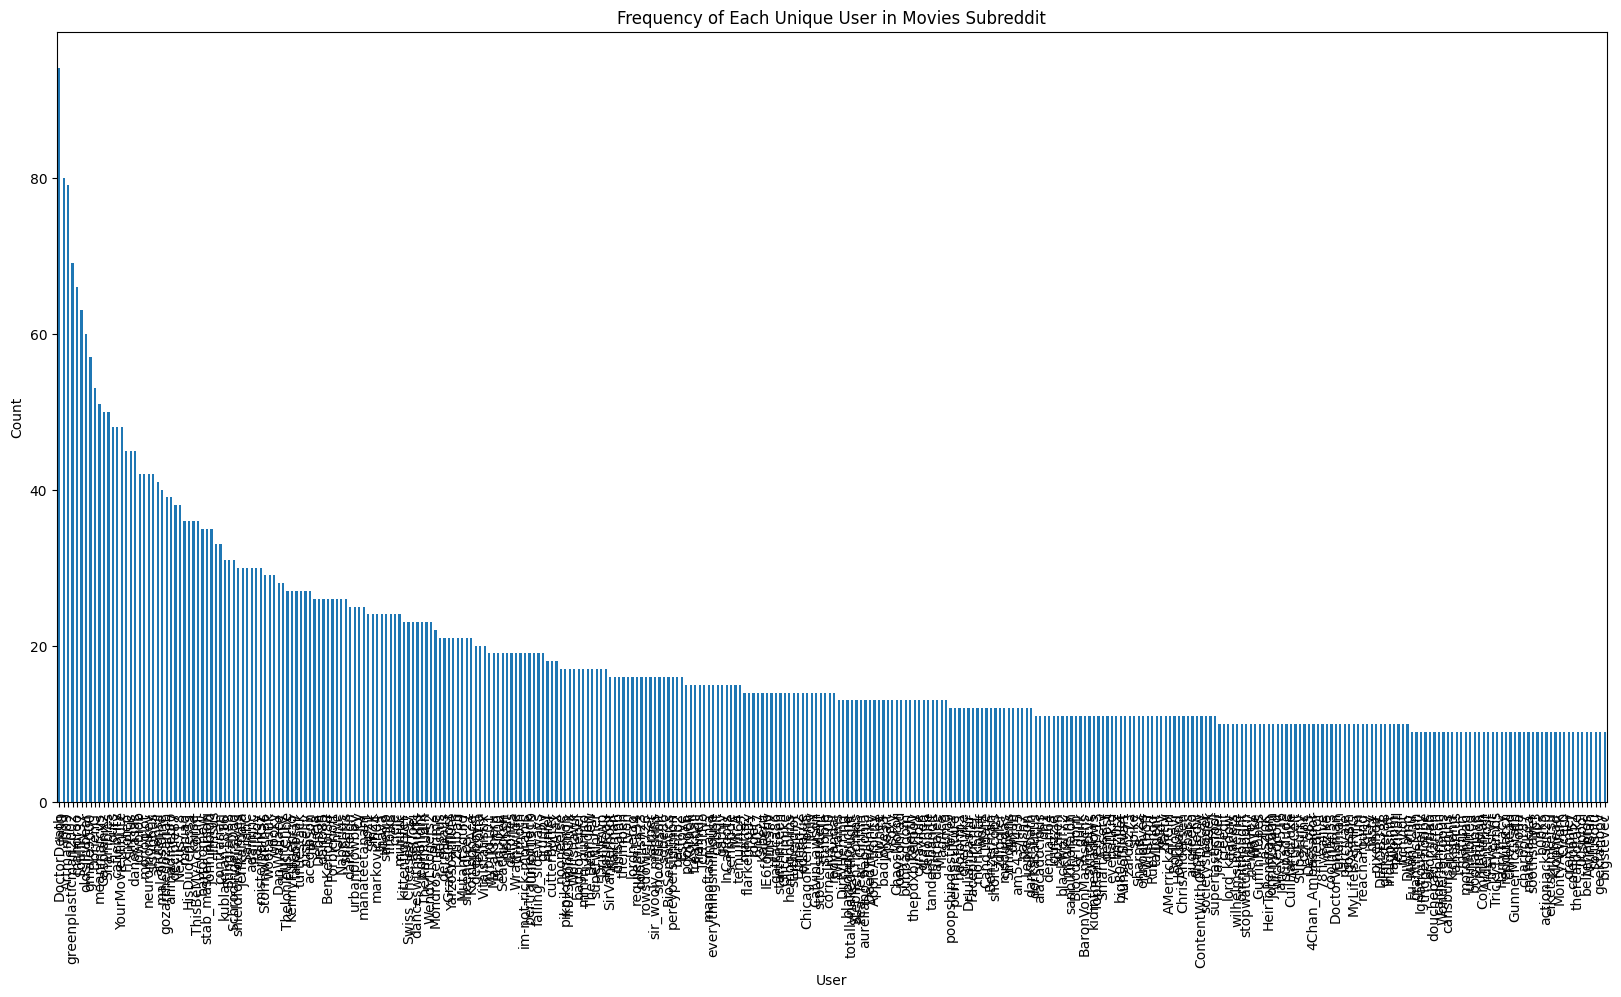

In [27]:
# Filter the dataframe for rows where subreddit is "movies"
movies_df = metadata[metadata['subreddit'] == 'movies']

# Get the frequency counts of each unique user
user_counts = movies_df['author'].value_counts()

# Keep only the top users based on counts
top_users = user_counts[user_counts >= user_counts.quantile(0.90)]

top_users.plot(kind='bar', figsize=(20, 10))
plt.xlabel('User')
plt.ylabel('Count')
plt.title('Frequency of Each Unique User in Movies Subreddit')
plt.show()

In [31]:
type(top_users)

pandas.core.series.Series

In [30]:
top_users

author
DoctorDeath            94
jh99                   80
Artman009              79
greenplasticman2002    69
mahdroo                66
                       ..
beltenebros             9
AlvinBlah               9
solusolu                9
geekfanboy              9
bigstevec               9
Name: count, Length: 346, dtype: int64

In [29]:
embeddings = utils.load_embeddings(2010, 1, embed_path=g['embed_path'])
embeddings = embeddings[movies_df['idx']]
embeddings.shape

(13303, 384)

In [16]:
soi = 'movies'

metadata = ['id', 'name', 'created_utc', 'parent_id', 
            'subreddit', 'subreddit_id', 'author']

reader = utils.read_file(
    os.path.join(DATA_PATH, 'RC_2010-01.bz2'), 
    return_type='metadata',
    metadata=metadata, 
    chunk_size=10000
)

res = []

# k will keep track of line and should align with embeddings
k = 0
for chunk in reader:
    for entry in chunk:
        if entry['subreddit'] == soi:
            entry['idx'] = k
            res.append(entry)
        k += 1

In [17]:
df_res = pd.DataFrame(res)
df_res.head()

,id,name,created_utc,parent_id,subreddit,subreddit_id,author,idx
0,c0i12y9,t1_c0i12y9,1262304136,t3_akd1b,movies,t5_2qh3s,bbittner,69
1,c0i12yf,t1_c0i12yf,1262304145,t1_c0i0xg6,movies,t5_2qh3s,passingby,75
2,c0i136p,t1_c0i136p,1262304464,t3_akc13,movies,t5_2qh3s,andhelostthem,293
3,c0i13at,t1_c0i13at,1262304618,t1_c0i0y0u,movies,t5_2qh3s,Wrathwilde,411
4,c0i13mq,t1_c0i13mq,1262305018,t3_akd1b,movies,t5_2qh3s,rawbinm,752


In [23]:
embeddings = utils.load_embeddings(2010, 1)

# grab just within subreddit
idx = df_res['idx'].values
embeddings = embeddings[idx]

In [24]:
embeddings.shape

(13303, 384)